In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
data_dir = 'breast-cancer-data'

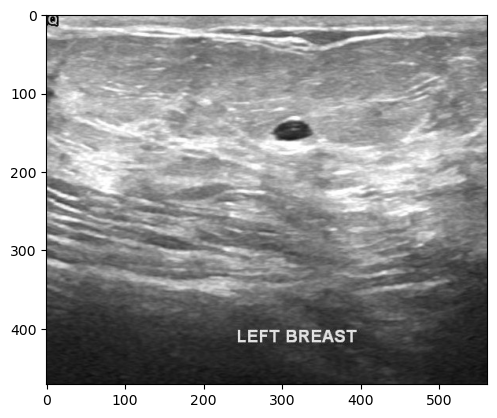

In [9]:
import matplotlib.image as mping
test_image = "breast-cancer-data/benign/benign (1).png"
img = mping.imread(test_image)
plt.imshow(img)

In [10]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [13]:
class_names = train_ds.class_names
class_names

['benign', 'malignant', 'normal']

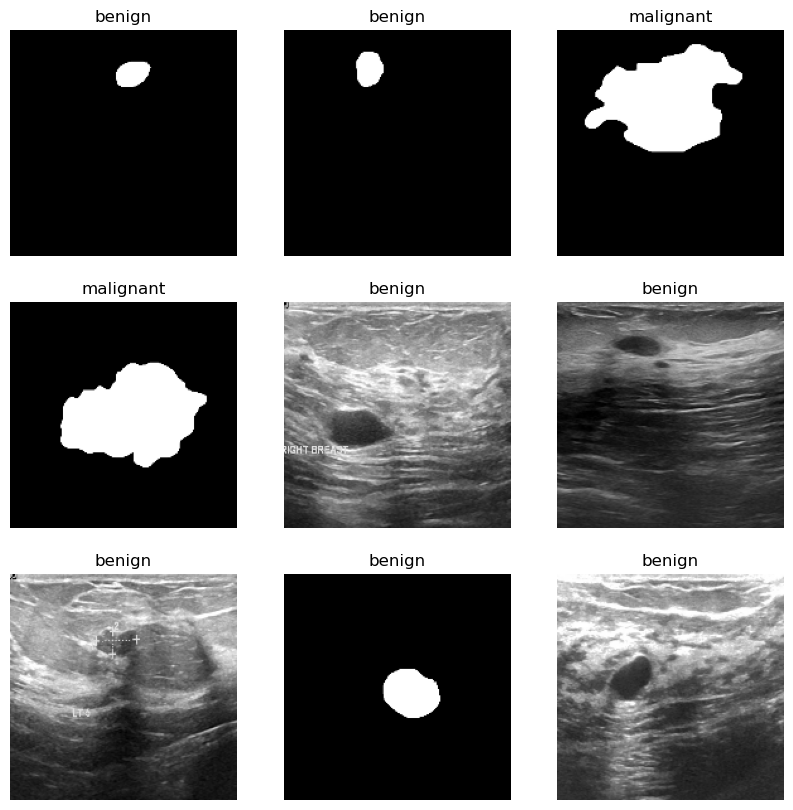

In [15]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [19]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# Standadrize the values in the [0,1] RGB channel range by using tf.keras.Rescaling
normailization_layers = layers.Rescaling(1./255)

In [26]:
# create a keras model
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3, padding='same', activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same',  activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [27]:
# compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [29]:
# train the model for 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
40/40 [==============================] - 80s 1s/step - loss: 0.9274 - accuracy: 0.5487 - val_loss: 0.8223 - val_accuracy: 0.6222
Epoch 2/10
40/40 [==============================] - 43s 1s/step - loss: 0.6558 - accuracy: 0.7110 - val_loss: 0.7386 - val_accuracy: 0.7048
Epoch 3/10
40/40 [==============================] - 43s 1s/step - loss: 0.5145 - accuracy: 0.7751 - val_loss: 0.8088 - val_accuracy: 0.7048
Epoch 4/10
40/40 [==============================] - 43s 1s/step - loss: 0.4184 - accuracy: 0.8369 - val_loss: 0.9109 - val_accuracy: 0.7270
Epoch 5/10
40/40 [==============================] - 43s 1s/step - loss: 0.3275 - accuracy: 0.8797 - val_loss: 0.9606 - val_accuracy: 0.7492
Epoch 6/10
40/40 [==============================] - 43s 1s/step - loss: 0.2366 - accuracy: 0.9208 - val_loss: 1.3692 - val_accuracy: 0.7460
Epoch 7/10
40/40 [==============================] - 46s 1s/step - loss: 0.1517 - accuracy: 0.9541 - val_loss: 1.4639 - val_accuracy: 0.7333
Epoch 8/10
40/40 [==

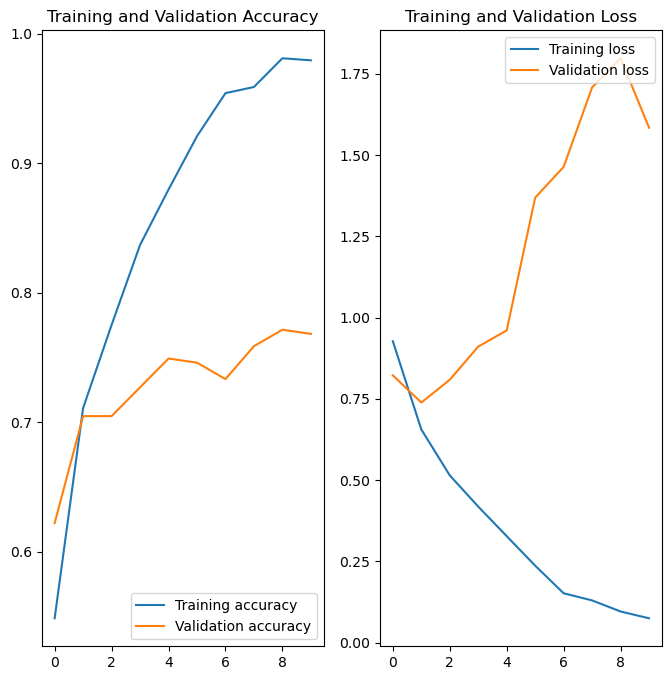

In [31]:
# visualize training rsults by ploting plots for accuracy and loss on thr training and validation sets

acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [32]:
# reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

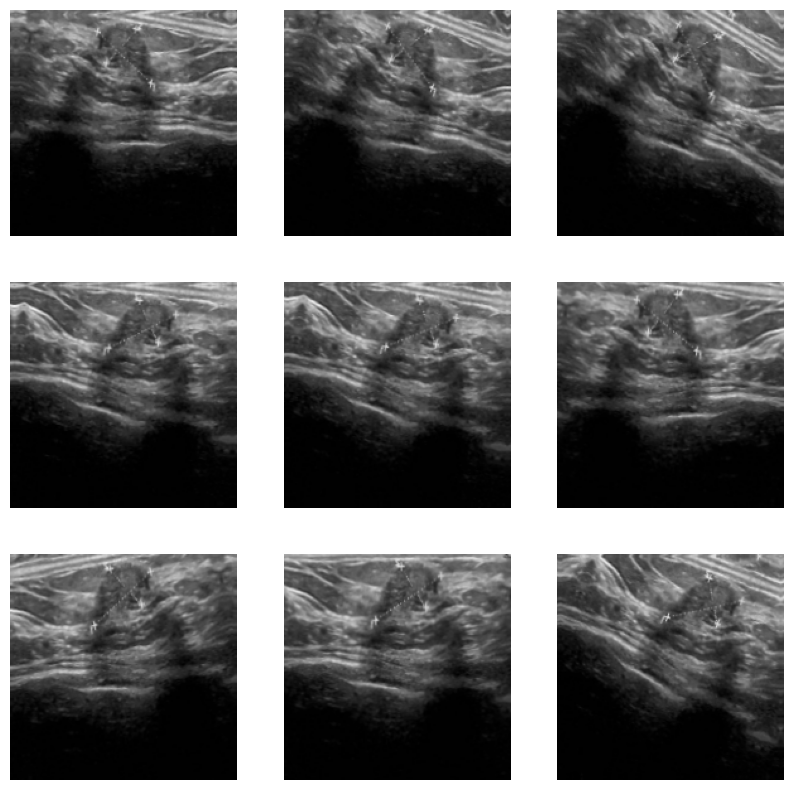

In [34]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [35]:
# intoduce Dropout in the network to help reduce overfitting further

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])

In [36]:
# compile and train the model
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [38]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
40/40 [==============================] - 59s 1s/step - loss: 0.8970 - accuracy: 0.5542 - val_loss: 0.8368 - val_accuracy: 0.5714
Epoch 2/15
40/40 [==============================] - 51s 1s/step - loss: 0.7807 - accuracy: 0.6698 - val_loss: 0.8302 - val_accuracy: 0.6381
Epoch 3/15
40/40 [==============================] - 50s 1s/step - loss: 0.7151 - accuracy: 0.6912 - val_loss: 0.7229 - val_accuracy: 0.6730
Epoch 4/15
40/40 [==============================] - 50s 1s/step - loss: 0.6424 - accuracy: 0.7023 - val_loss: 0.7987 - val_accuracy: 0.6825
Epoch 5/15
40/40 [==============================] - 50s 1s/step - loss: 0.6476 - accuracy: 0.7205 - val_loss: 0.6360 - val_accuracy: 0.7048
Epoch 6/15
40/40 [==============================] - 50s 1s/step - loss: 0.5997 - accuracy: 0.7458 - val_loss: 0.6756 - val_accuracy: 0.7048
Epoch 7/15
40/40 [==============================] - 50s 1s/step - loss: 0.5743 - accuracy: 0.7466 - val_loss: 0.6873 - val_accuracy: 0.6952
Epoch 8/15
40/40 [==